# Visualisations of the Tracked _Real_ Events (OSTIA Observations) using `plotX`
cf. Plots when exchange for Basic Tracking (i.e. `extreme_events_basic_gridded.zarr`)

In [1]:
from getpass import getuser
from pathlib import Path

import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import marEx
import marEx.helper as hpc

In [2]:
# Directories
scratch_dir = Path("/scratch") / getuser()[0] / getuser()  # Lustre Scratch Directory

file_name = scratch_dir / "mhws" / "extreme_events_merged_gridded_shifting.zarr"
plot_dir = scratch_dir / "mhws" / "plots"

In [3]:
# Start Dask Cluster
client = hpc.start_local_cluster(
    n_workers=32, threads_per_worker=1, scratch_dir=scratch_dir / "clients"
)  # Specify temporary scratch directory for dask to use

Hostname: l40145
Forward Port: l40145:8787
Dashboard Link: localhost:8787/status


In [4]:
# Import Tracked Extremes DataSet
extreme_events_ds = xr.open_zarr(str(file_name), chunks={})
extreme_events_ds

<xarray.Dataset> Size: 47GB
Dimensions:       (ID: 13614, time: 9282, lat: 720, lon: 1440, component: 2,
                   sibling_ID: 11)
Coordinates:
  * ID            (ID) int32 54kB 1 2 3 4 5 6 ... 13610 13611 13612 13613 13614
  * lat           (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon           (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time          (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-05-...
Dimensions without coordinates: component, sibling_ID
Data variables:
    ID_field      (time, lat, lon) int32 38GB dask.array<chunksize=(25, 720, 1440), meta=np.ndarray>
    area          (time, ID) float32 505MB dask.array<chunksize=(25, 13614), meta=np.ndarray>
    centroid      (component, time, ID) float64 2GB dask.array<chunksize=(2, 25, 13614), meta=np.ndarray>
    global_ID     (time, ID) int32 505MB dask.array<chunksize=(25, 13614), meta=np.ndarray>
    merge_ledger  (time, ID, sibling_ID) int32 6GB dask.array<chunksize=(25, 13614, 11), meta=np.ndarray>
    presence      (time, ID) bool 126MB dask.array<chunksize=(25, 13614), meta=np.ndarray>
    time_end      (ID) datetime64[ns] 109kB dask.array<chunksize=(13614,), meta=np.ndarray>
    time_start    (ID) datetime64[ns] 109kB dask.array<chunksize=(13614,), meta=np.ndarray>
Attributes: (12/14)
    N_events_final:              13614
    N_objects_filtered:          125109
    N_objects_prefiltered:       250096
    R_fill:                      8
    T_fill:                      2
    accepted_area_fraction:      0.9250359966957292
    ...                          ...
    area_threshold (cells):      714.0
    multi_parent_merges:         6763
    nn_partitioning:             1
    overlap_threshold:           0.5
    preprocessed_area_fraction:  0.603239018193744
    total_merges:                26739

In [5]:
# Extract the Events ID Field
ID_field = extreme_events_ds.ID_field
ID_field

<xarray.DataArray 'ID_field' (time: 9282, lat: 720, lon: 1440)> Size: 38GB
dask.array<open_dataset-ID_field, shape=(9282, 720, 1440), dtype=int32, chunksize=(25, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-05-31T12...

## Make a Movie using `plotX.animate`
N.B.: Making `dask`-powered movies using `animate()` cannot be threaded !

In [ ]:
# Choose a subset of the ID field
ID_field_subset = ID_field.sel(time=slice("2020-01-01", "2022-05-31"))

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True)
ID_field_subset.plotX.animate(
    config, plot_dir=plot_dir, file_name="movie_ID_field_gridded"
)

In [7]:
%%HTML
<video width="640" height="480" controls>
    <source src="../../media/movie_ID_field_gridded.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

cf. "Basic" Tracking, i.e. the current standard method in the literature, involving _No_ temporal gap filling, _No_ merging/splitting and _No_ independent event tracking. 

In [ ]:
# Choose a subset of the "Basic" ID field
ID_field_basic_subset = xr.open_zarr(
    str(file_name).replace("merged", "basic"), chunks={}
).ID_field.sel(time=slice("2020-01-01", "2022-05-31"))

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True)
ID_field_basic_subset.plotX.animate(
    config, plot_dir=plot_dir, file_name="movie_ID_field_basic_gridded"
)

In [9]:
%%HTML
<video width="640" height="480" controls>
    <source src="../../media/movie_ID_field_basic_gridded.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

## Plot Consecutive Days of Extreme Events

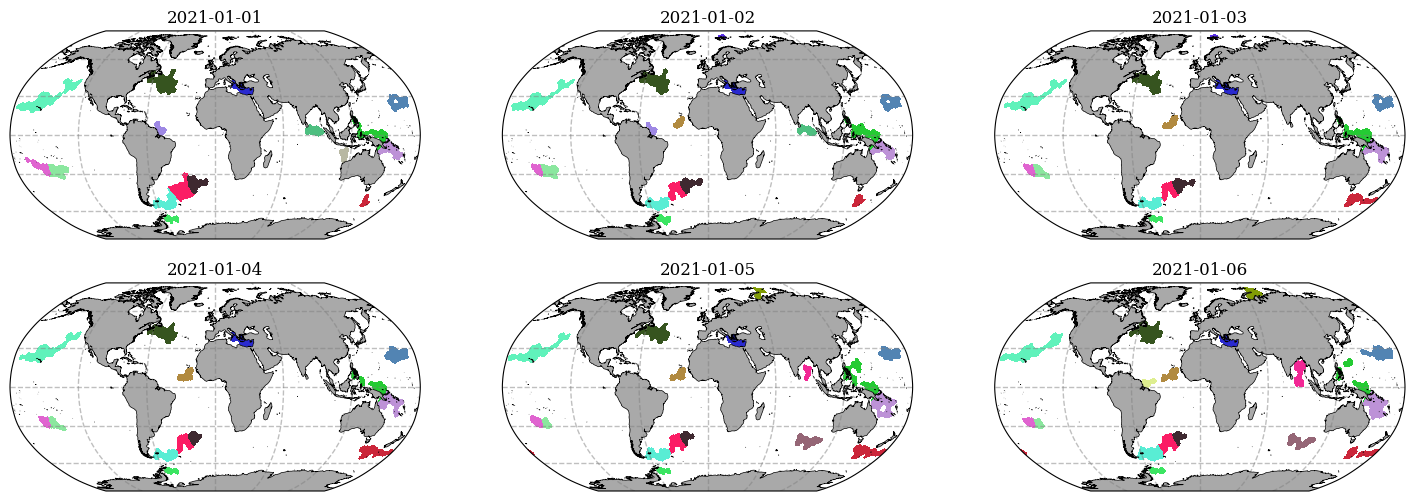

In [10]:
# Choose a subset of the ID field
ID_field_subset = ID_field.sel(time=slice("2021-01-01", "2021-01-06"))

# Setup Plotting Configuration
config = marEx.PlotConfig(plot_IDs=True)
fig, ax = ID_field_subset.plotX.multi_plot(config, col="time", col_wrap=3);

## Plot Consecutive Months of Extreme Events

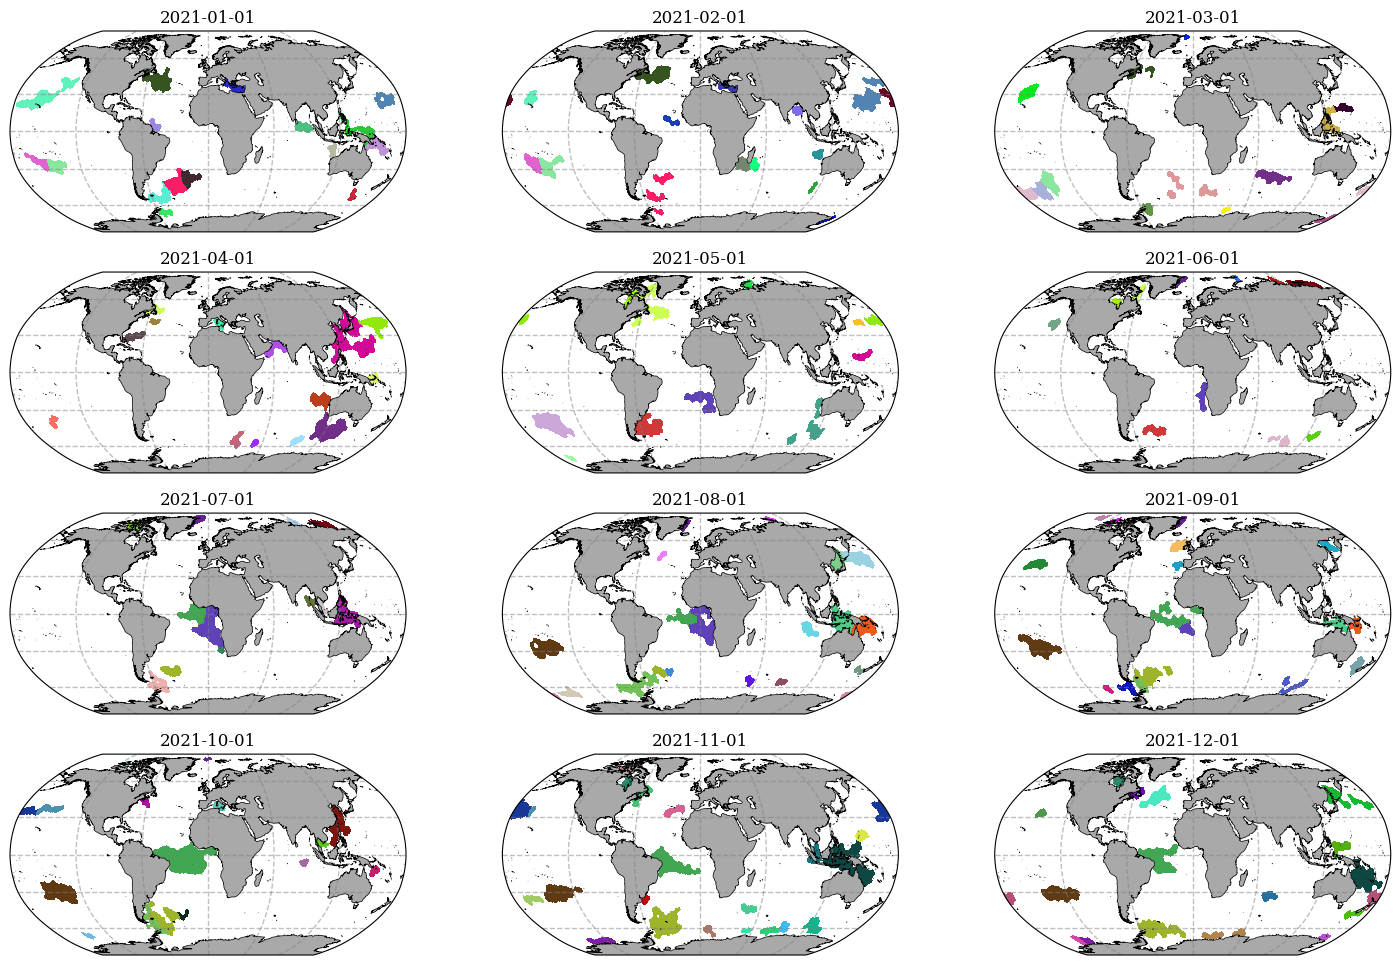

In [11]:
# Choose the first day of each month from a subset of the ID field
ID_field_subset_day1 = (
    ID_field.sel(time=slice("2021-01-01", "2021-12-31")).resample(time="MS").nearest()
)

# Setup Plotting Configuration
config = marEx.PlotConfig(plot_IDs=True)
fig, ax = ID_field_subset_day1.plotX.multi_plot(config, col="time", col_wrap=3);

## Plot Global Extreme Event Frequency

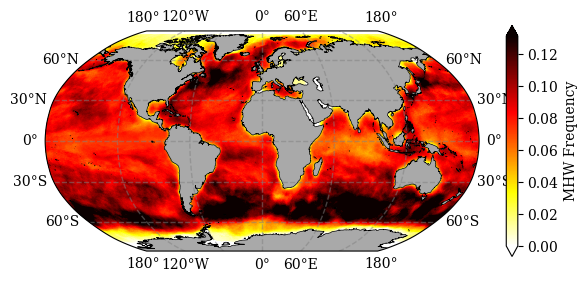

In [12]:
# Calculate the frequency of Event Occurrence
event_frequency = (ID_field > 0).mean("time")

# Setup Plotting Configuration
config = marEx.PlotConfig(
    var_units="MHW Frequency", cmap="hot_r", cperc=[0, 96], grid_labels=True
)
fig, ax, im = event_frequency.plotX.single_plot(config)

## Plot Seasonal Extreme Event Frequency

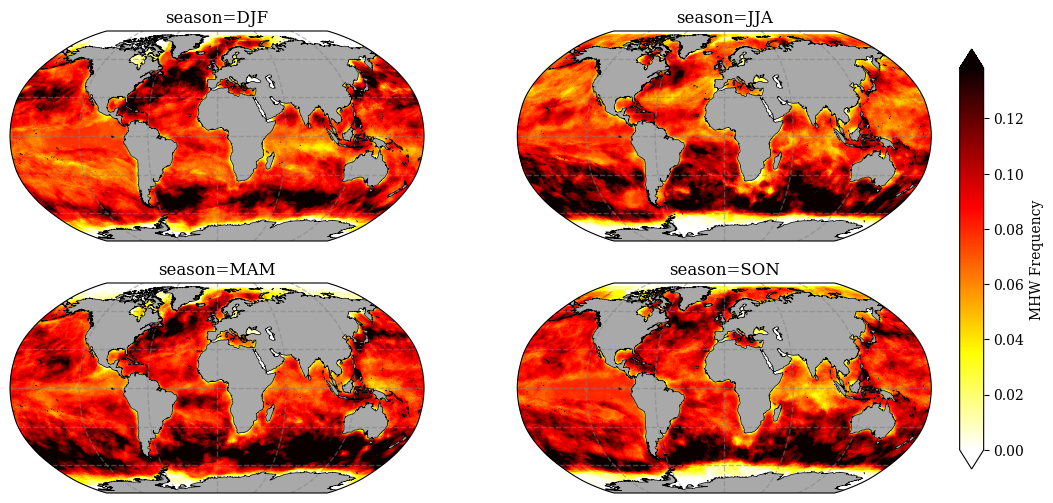

In [13]:
# Calculate the frequency of Event Occurrence per season
seasonal_frequency = (ID_field > 0).groupby("time.season").mean(dim="time")

# Setup Plotting Configuration
config = marEx.PlotConfig(
    var_units="MHW Frequency", cmap="hot_r", cperc=[0, 96], grid_labels=True
)
fig, ax = seasonal_frequency.plotX.multi_plot(config, col="season", col_wrap=2);

## Find & Plot a Few of the Longest Events (and **The Blob**!)

In [6]:
events_duration = extreme_events_ds.time_end - extreme_events_ds.time_start
longest_events = events_duration.sortby(events_duration, ascending=False).ID

for ID in longest_events[:10].values:
    print(
        f"ID: {ID:<6}   Start Day: {extreme_events_ds.time_start.sel(ID=ID).dt.strftime('%Y-%m-%d').values}  -->  Duration: {events_duration.sel(ID=ID).dt.days.values:<4} days"
    )

ID: 9220     Start Day: 2015-05-03  -->  Duration: 790  days
ID: 8765     Start Day: 2014-07-28  -->  Duration: 774  days
ID: 8831     Start Day: 2014-09-02  -->  Duration: 662  days
ID: 6631     Start Day: 2010-08-21  -->  Duration: 520  days
ID: 146      Start Day: 1997-05-10  -->  Duration: 518  days
ID: 5858     Start Day: 2009-04-27  -->  Duration: 478  days
ID: 6417     Start Day: 2010-05-04  -->  Duration: 425  days
ID: 132      Start Day: 1997-04-28  -->  Duration: 418  days
ID: 9834     Start Day: 2016-03-28  -->  Duration: 383  days
ID: 501      Start Day: 1998-01-23  -->  Duration: 378  days


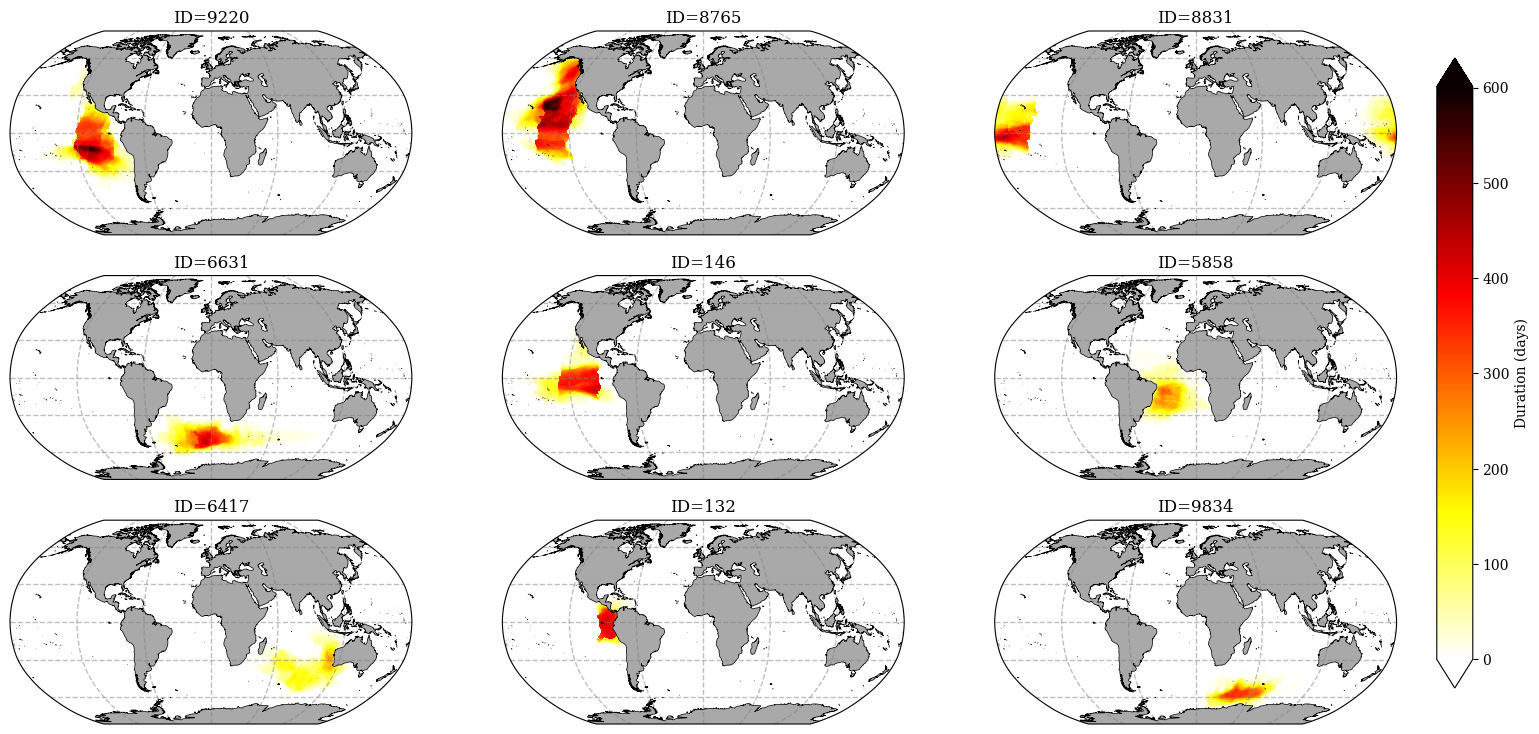

In [7]:
# Calculate the local duration of the longest events
long_events = ID_field == (longest_events[:9]).chunk({"ID": 1})
long_events_local_duration = (long_events > 0).sum("time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="Duration (days)", cmap="hot_r", cperc=[0, 100])
fig, ax = long_events_local_duration.plotX.multi_plot(config, col="ID", col_wrap=3);

## ID Maximum and Mean Event Area
Units for `extreme_events_ds.area` when using gridded data is 'cells'. Here we must convert to km².

In [8]:
# Calculate grid areas
R_earth = 6371. #km
resolution = 0.25 #deg

lat_r, lon_r, dlat, dlon = np.radians(extreme_events_ds.lat), np.radians(extreme_events_ds.lon), np.radians(resolution), np.radians(resolution)
grid_area = (R_earth**2 * np.abs(np.sin(lat_r + dlat/2) - np.sin(lat_r - dlat/2)) * dlon).astype(np.float32)

In [15]:
def compute_areas_by_id(id_field, grid_area, unique_ids, presence):
    """Compute area for each ID using efficient indexing"""
    # Broadcast grid_area to match id_field shape
    grid_broadcast = np.broadcast_to(grid_area[:, np.newaxis], id_field.shape)
    areas = np.zeros(len(unique_ids), dtype=np.float32)
    
    # Vectorised accumulation
    flat_ids = id_field.ravel()
    flat_grid = grid_broadcast.ravel()
    
    for idx, id_val in enumerate(unique_ids):
        if presence[idx]: # Only process non-zero IDs
            areas[idx] = flat_grid[flat_ids == id_val].sum()
        else:
            areas[idx] = 0.0
    
    return areas

areas = xr.apply_ufunc(
    compute_areas_by_id,
    extreme_events_ds.ID_field,
    grid_area,
    extreme_events_ds.ID,
    extreme_events_ds.presence,
    input_core_dims=[['lat', 'lon'], ['lat'], ['ID'], ['ID']],
    output_core_dims=[['ID']],
    dask='parallelized',
    vectorize=True,
    output_dtypes=[np.float32]
)

areas = areas.where(extreme_events_ds.presence, np.nan).compute()

In [16]:
areas_max = areas.max().compute()
print(f'Maximum object area: {areas_max.values:.0f} km²')

areas_mean = areas.mean().compute()
print(f'Mean object area: {areas_mean.values:.0f} km²')

Maximum object area: 26279288 km²
Mean object area: 2006453 km²


## Time-Series Plot of Events Area

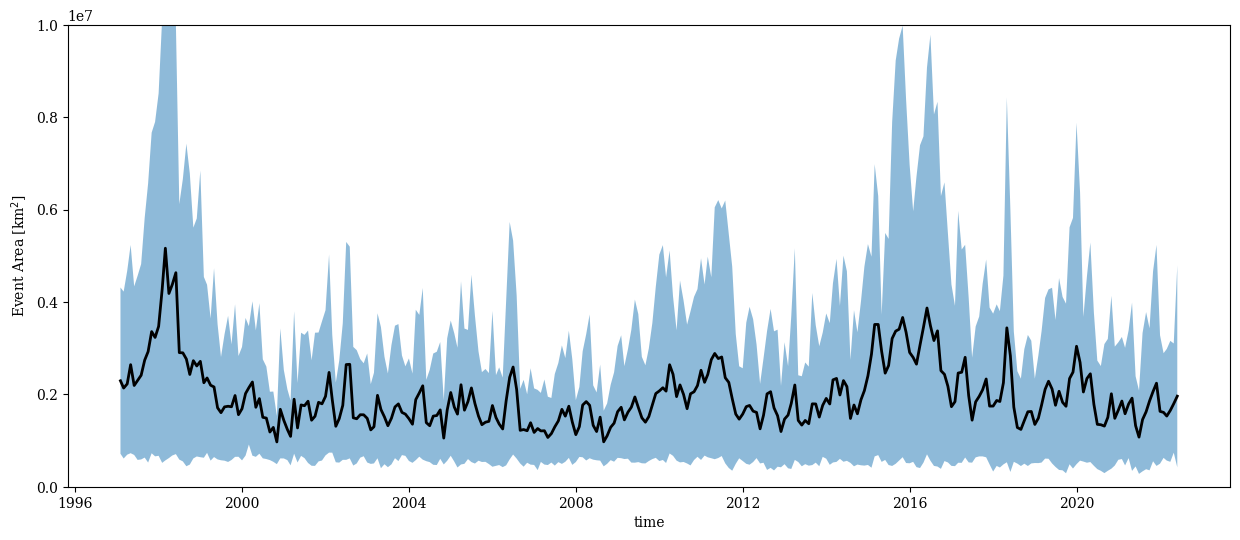

In [17]:
area_mean = areas.mean("ID").resample(time="ME").mean()

area_10 = areas.reduce(np.nanpercentile, q=10, dim="ID").resample(time="ME").mean()
area_90 = areas.reduce(np.nanpercentile, q=90, dim="ID").resample(time="ME").mean()

plt.figure(figsize=(15, 6))
area_mean.plot(label="Mean Area", color="k", lw=2)
plt.fill_between(area_mean.time.values, area_10, area_90, alpha=0.5)
plt.ylim([0, 1e7])
plt.ylabel(r"Event Area [km$^2$]");

## Hovmüller Plot of MHW Monthly Frequency vs Latitude

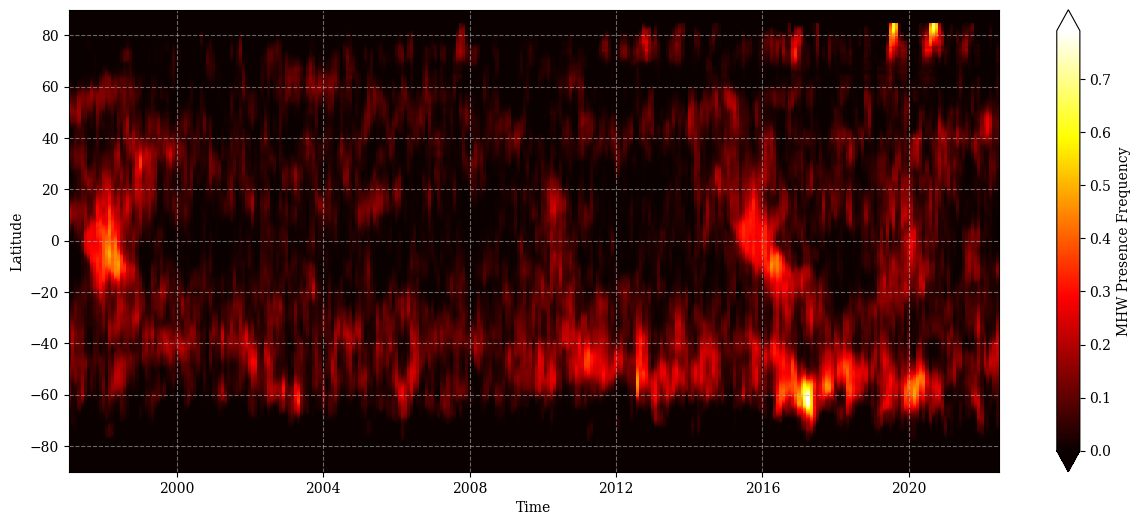

In [12]:
spatial_presence = (ID_field > 0).mean(dim="lon").resample(time="ME").mean()

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence.plot(
    ax=ax,
    cmap="hot",
    x="time",
    cbar_kwargs={"label": "MHW Presence Frequency", "extend": "both"},
)

ax.set_xlabel("Time")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", alpha=0.6)

## Seasonal Cycle of MHW vs Latitude

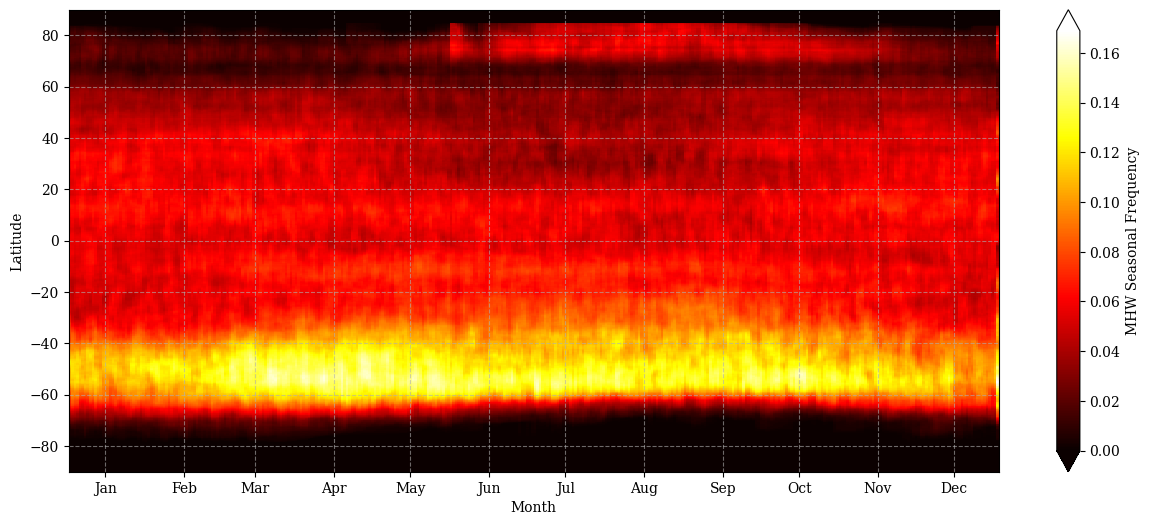

In [13]:
spatial_presence_seasonal = (
    (ID_field > 0).mean(dim="lon").groupby("time.dayofyear").mean()
)

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence_seasonal.plot(
    ax=ax,
    cmap="hot",
    x="dayofyear",
    cbar_kwargs={"label": "MHW Seasonal Frequency", "extend": "both"},
)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_positions = np.cumsum([0] + days_per_month[:-1]) + 15

ax.set_xticks(month_positions)
ax.set_xticklabels(months)
ax.set_xlabel("Month")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", alpha=0.6)